### XGBoost (fake news detection)

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# # Silent warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Load preprocessed data

In [2]:
with open('preprocessed_X.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('preprocessed_y.pkl', 'rb') as f:
    y = pickle.load(f)

### Split data into train and test set

In [3]:
# Split data into train and test sets in ratio 75%/25% (pseudo randomized random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28941, 5000), (28941,), (9648, 5000), (9648,))

### XGBoost default parameters 

In [4]:
xgb_cl = xgb.XGBClassifier(random_state=42)
xgb_cl.fit(X_train, y_train)

# # Returning classification report
print(classification_report(y_test, xgb_cl.predict(X_test), target_names = ['Fake', 'Real']))

[20:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      4345
        Real       0.98      0.99      0.99      5303

    accuracy                           0.99      9648
   macro avg       0.99      0.98      0.98      9648
weighted avg       0.99      0.99      0.99      9648



In [5]:
xgb_cl.get_params(deep=True)

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

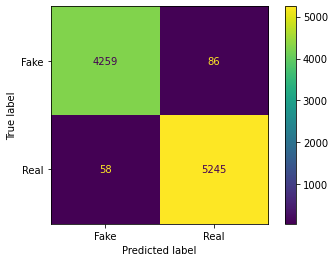

In [6]:
plot_confusion_matrix(xgb_cl, X_test, y_test, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### Parameters tuned XGBoost

In [7]:
# Find optimal hyperparameters

# xgb_params_grid = {'colsample_bytree': [0.5, 0.7, 0.9],                   
#                    'gamma': [0, 0.3, 0.5],
#                    'learning_rate': [0.01, 0.1, 0.2],
#                    'max_depth': [2, 4, 6, 8],                   
#                    'reg_alpha': [0, 0.5, 1],                   
#                    'reg_lambda': [0, 0.5, 1],
#                    'subsample': [0.5, 0.7, 0.9],
#                   }

xgb_params_grid = {'colsample_bytree': [0.5],                   
                   'gamma': [0.5],
                   'learning_rate': [0.2],
                   'max_depth': [8],                   
                   'reg_alpha': [0],                   
                   'reg_lambda': [0.5],
                   'subsample': [0.9],
                  }

xgb_grid = GridSearchCV(estimator=xgb.XGBClassifier(),
                       param_grid=xgb_params_grid,
                       cv=3,     
                       verbose=0,
                       n_jobs=-1
                      )

xgb_grid.fit(X_train, y_train)

[20:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [8]:
xgb_grid.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.5,
 'learning_rate': 0.2,
 'max_depth': 8,
 'reg_alpha': 0,
 'reg_lambda': 0.5,
 'subsample': 0.9}

In [9]:
xgb_param_tuned = xgb.XGBClassifier().set_params(**xgb_grid.best_params_)
xgb_param_tuned.fit(X_train, y_train)

# Returning classification report
print(classification_report(y_test, xgb_param_tuned.predict(X_test), target_names = ['Fake', 'Real']))

[20:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      4345
        Real       0.98      0.99      0.99      5303

    accuracy                           0.99      9648
   macro avg       0.99      0.98      0.99      9648
weighted avg       0.99      0.99      0.99      9648



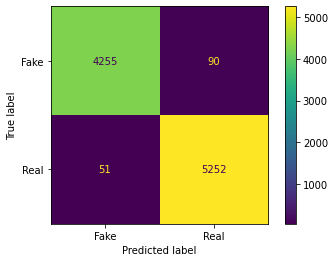

In [10]:
plot_confusion_matrix(xgb_param_tuned, X_test, y_test, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### Save tuned and trained Random Forest Classifier 

In [11]:
with open('XGBoost_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_param_tuned, f)

### Plot Receiver operating characteristic (ROC) curve

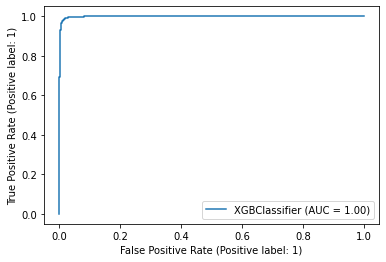

In [12]:
metrics.plot_roc_curve(xgb_param_tuned, X_test, y_test) 
plt.show()